In [161]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import librosa
import numpy as np
import noisereduce as nr
from scipy.signal import butter, filtfilt,firwin,lfilter,firls
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio, display
from pprint import pprint
import pywt
import os

In [163]:
def highpass_filter(data, cutoff_freq, fs, order=5):
    """
    Apply a highpass filter to the input data.

    Parameters:
    data (array): Input signal
    cutoff_freq (float): Cutoff frequency of the filter (Hz)
    fs (float): Sampling frequency (Hz)
    order (int): Order of the filter (default: 5)

    Returns:
    y (array): Filtered signal
    """
    nyquist = 0.5 * fs
    cutoff = cutoff_freq / nyquist
    b, a = butter(order, cutoff, btype='high', analog=False, output='ba')
    y = filtfilt(b, a, data)
    return y

def fir_bandpass_filter(data, lowcut, highcut, fs, numtaps=2048,window = 'hamming'):
    """
    Design and apply an FIR bandpass filter to the input data.

    Parameters:
    data (array): Input audio signal
    lowcut (float): Lower cutoff frequency (Hz)
    highcut (float): Upper cutoff frequency (Hz)
    fs (float): Sampling frequency (Hz)
    numtaps (int): Number of filter taps (default: 101)

    Returns:
    y (array): Filtered audio signal
    """
    nyquist = 0.5 * fs
    low = (lowcut)/ nyquist
    high = (highcut) / nyquist
    b = firwin(numtaps, [low, high], pass_zero=False, window = window)
    b = b / np.sum(b)  # Normalize filter coefficients
    y = filtfilt(b, 1.0, data)
    # Apply filter
    return y


def fir_leastsquares_bandpass(data, lowcut, highcut, fs, numtaps=256):
    """
    Design and apply an FIR bandpass filter using the least squares method.

    Parameters:
    data (array): Input audio signal
    lowcut (float): Lower cutoff frequency (Hz)
    highcut (float): Upper cutoff frequency (Hz)
    fs (float): Sampling frequency (Hz)
    numtaps (int): Number of filter taps (default: 256)

    Returns:
    y (array): Filtered audio signal
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    bands = [0, low * 0.9, low, high, high * 1.1, nyquist]
    desired = [0, 0, 1, 1, 0, 0]
    b = firls(numtaps, bands, desired)
    y = filtfilt(b, 1.0, data)
    return y


# def fir_bandpass_filter(data, lowcut, highcut, fs, numtaps=2048, window='hamming'):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b = firwin(numtaps, [low, high], pass_zero=False, window=window)
#     b = b / np.sum(b)  # Normalize filter coefficients
#     y = filtfilt(b, 1.0, data)
#     return y

def normalize_audio(audio):
    """
    Normalize the amplitude of the audio signal.

    Parameters:
    audio (array): Input audio signal

    Returns:
    y (array): Normalized audio signal
    """
    y = audio / np.max(np.abs(audio))
    return y

def normalize_amplitude(original, processed):
    original_rms = np.sqrt(np.mean(original**2))
    processed_rms = np.sqrt(np.mean(processed**2))
    if processed_rms == 0:  # Avoid division by zero
        return processed
    gain = original_rms / processed_rms
    return processed * gain

def noisereduce_wav(y, sr=22050):
    epsilon = 1e-10
    y = nr.reduce_noise(y=y+epsilon,stationary=False, sr=sr,n_fft=2048,
                        prop_decrease=0.99,
                        win_length=2048,
                        hop_length=512,
                        time_mask_smooth_ms=50,
                        freq_mask_smooth_hz=50,
                        n_jobs=-1)
    return y


# def noisereduce_wav(y, sr=22050):
#     epsilon = 1e-10
#     y = nr.reduce_noise(y=y+epsilon,stationary=False, sr=sr,n_fft=2048,
#                         prop_decrease=0.99,
#                         win_length=2048,
#                         hop_length=512,
#                         time_mask_smooth_ms=24,
#                         freq_mask_smooth_hz=22,
#                         n_jobs=-1)
#     return y

def match_target_amplitude(y, target_dBFS = -20):
    """
    Used to standardize volume of audio clip.

    Arguments:
    y -- audio time series
    target_dBFS -- target dBFS level

    Returns:
    y -- audio time series with standardized volume
    """
    rms = (y ** 2).mean() ** 0.5
    scalar = 10 ** (target_dBFS / 20) / (rms + 1e-9)
    return y * scalar


# # def load_audio(file_path, target_sr=None, target_dBFS=-20):
# #     """
# #     Load and resample an audio file, apply bandpass filtering, volume matching, 
# #     noise reduction, and normalization to a target dBFS.

# #     Arguments:
# #     file_path -- path to the audio file
# #     target_sr -- target sampling rate (None for original sampling rate)
# #     target_dBFS -- target decibel Full Scale (dBFS) for amplitude normalization

# #     Returns:
# #     y -- original audio time series
# #     y_denoised -- processed audio time series
# #     sr -- sampling rate
# #     """
# #     # Load the audio file
# #     y, sr = librosa.load(file_path, sr=target_sr)
    
# #     # Match target amplitude to ensure consistent volume levels before processing
# #     y_normalized = match_target_amplitude(y, target_dBFS)
    
# #     # Apply bandpass filter
# #     y_denoised = fir_bandpass_filter(y_normalized, 150, 700, sr)
    
# #     # Apply noise reduction
# #     y_denoised = noisereduce_wav(y_denoised)
    
# #     # Match target amplitude again to ensure consistent volume levels after processing
# #     y_denoised = match_target_amplitude(y_denoised, target_dBFS)
    
# #     return y, y_denoised, sr


def load_audio(file_path, target_sr=22050):
    """
    Load and resample an audio file, apply bandpass filtering, volume matching, 
    noise reduction, and normalization.

    Arguments:
    file_path -- path to the audio file
    target_sr -- target sampling rate (None for original sampling rate)

    Returns:
    y -- original audio time series
    y_denoised -- processed audio time series
    sr -- sampling rate
    """
    # Load the audio file
    y, sr = librosa.load(file_path, sr=target_sr)
    
    # Apply bandpass filter
    y_denoised = fir_bandpass_filter(y, 150, 600, sr)
    
    # Match target amplitude to ensure consistent volume levels before processing
    y_denoised = match_target_amplitude(y_denoised)
    
    # Apply noise reduction
    y_denoised = noisereduce_wav(y_denoised)
    
    # Match target amplitude again to ensure consistent volume levels after processing
    y_denoised = match_target_amplitude(y_denoised)
    
    return y, y_denoised, sr

## Using VGGish to detect speech

In [118]:
# import os
# import numpy as np
# import librosa
# import tensorflow as tf
# import tensorflow_hub as hub

# # Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# # Load the VGGish model
# vggish_model = hub.load("https://tfhub.dev/google/vggish/1")

# def vggish_embeddings(audio, sr):
#     """
#     Generate VGGish embeddings for an audio signal.
    
#     Parameters:
#         audio (ndarray): Audio time series.
#         sr (int): Sampling rate of the audio.
        
#     Returns:
#         embeddings (ndarray): VGGish embeddings.
#     """
#     # Resample to 16 kHz
#     audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=16000)
#     # Normalize the audio
#     audio_resampled = (audio_resampled - np.mean(audio_resampled)) / np.std(audio_resampled)
    
#     # Convert to mono
#     if audio_resampled.ndim > 1:
#         audio_resampled = np.mean(audio_resampled, axis=1)
    
#     # Extract embeddings
#     embeddings = vggish_model(audio_resampled)
#     return embeddings

# def detect_speech_segments_vggish(y, sr, threshold=0.5):
#     """
#     Detect speech segments in an audio signal using VGGish.
    
#     Parameters:
#         y (ndarray): Audio time series.
#         sr (int): Sampling rate of the audio.
#         threshold (float): Threshold for detecting speech.
        
#     Returns:
#         mask (ndarray): Boolean mask indicating non-speech segments.
#     """
#     # Get VGGish embeddings
#     embeddings = vggish_embeddings(y, sr)
    
#     # Sophisticated thresholding for speech detection
#     speech_probabilities = np.mean(embeddings, axis=1)
#     speech_segments = speech_probabilities > threshold
    
#     mask = np.ones_like(y, dtype=bool)
#     frame_length = len(y) // len(speech_segments)
    
#     for i, is_speech in enumerate(speech_segments):
#         start = i * frame_length
#         end = start + frame_length
#         if is_speech:
#             mask[start:end] = False
    
#     return mask

# def remove_speech_segments(y, sr, threshold=0.5):
#     """
#     Remove speech segments from an audio signal.
    
#     Parameters:
#         y (ndarray): Audio time series.
#         sr (int): Sampling rate of the audio.
#         threshold (float): Threshold for detecting speech.
        
#     Returns:
#         y_non_speech (ndarray): Audio time series with speech segments removed.
#     """
#     mask = detect_speech_segments_vggish(y, sr, threshold)
#     return y[mask]

# def load_audio(file_path, target_sr=None):
#     """
#     Load and resample an audio file, apply bandpass filtering, volume matching, 
#     noise reduction, and normalization.

#     Arguments:
#     file_path -- path to the audio file
#     target_sr -- target sampling rate (None for original sampling rate)

#     Returns:
#     y -- original audio time series
#     y_denoised -- processed audio time series
#     sr -- sampling rate
#     """
#     # Load the audio file
#     y, sr = librosa.load(file_path, sr=target_sr)
    
#     # Remove speech segments using VGGish
#     y_non_speech = remove_speech_segments(y, sr)
    
#     # Apply bandpass filter to isolate bird calls between 150-700 Hz
#     y_denoised = fir_bandpass_filter(y_non_speech, 150, 700, sr)
    
#     # Match target amplitude to ensure consistent volume levels before processing
#     y_denoised = match_target_amplitude(y_denoised)
    
#     # Apply noise reduction
#     y_denoised = noisereduce_wav(y_denoised)
    
#     # Match target amplitude again to ensure consistent volume levels after processing
#     y_denoised = match_target_amplitude(y_denoised)
    
#     return y, y_denoised, sr

## Wavelet transformation

In [119]:
import numpy as np
import librosa
import pywt

def min_max_freq(y, sr, threshold_factor=0.01, fallback_min_freq=20, fallback_max_freq=20000):
    """
    Calculate the minimum and maximum significant frequencies in the audio signal.
    
    Parameters:
        y (ndarray): Audio time series.
        sr (int): Sampling rate of the audio.
        threshold_factor (float): Factor to determine the threshold for significant frequencies.
        fallback_min_freq (float): Fallback minimum frequency if no significant frequencies are found.
        fallback_max_freq (float): Fallback maximum frequency if no significant frequencies are found.
    
    Returns:
        min_freq (float): Minimum significant frequency.
        max_freq (float): Maximum significant frequency.
    """
    # Compute the STFT
    D = np.abs(librosa.stft(y))

    # Compute the frequency axis
    frequencies = librosa.fft_frequencies(sr=sr)

    # Compute the average magnitude of the STFT across time
    average_magnitude = np.mean(D, axis=1)

    # Define a threshold to consider frequencies as significant
    threshold = np.max(average_magnitude) * threshold_factor

    # Find indices where the magnitude exceeds the threshold
    significant_indices = np.where(average_magnitude > threshold)[0]

    if len(significant_indices) == 0:
        print("No significant frequencies found, using fallback values.")
        return fallback_min_freq, fallback_max_freq
    
    # Identify the minimum and maximum frequencies
    min_freq = frequencies[significant_indices[0]]
    max_freq = frequencies[significant_indices[-1]]
    
    if min_freq <= 0 or max_freq <= 0:
        print(f"Detected minimum frequency: {min_freq}, maximum frequency: {max_freq}. Using fallback values.")
        return fallback_min_freq, fallback_max_freq
    
    return min_freq, max_freq


# Calculate the scales based on the desired frequencies
def calculate_scales(y, wavelet, sr, num_scales=20):
    dt = 1 / sr
    min_freq, max_freq = min_max_freq(y, sr)
    
    if min_freq == 0 or max_freq == 0:
        raise ValueError("Min and max frequencies must be greater than zero.")
    
    min_scale = pywt.scale2frequency(wavelet, [1])[0] / (max_freq * dt)
    max_scale = pywt.scale2frequency(wavelet, [1])[0] / (min_freq * dt)
    
    if not np.isfinite(min_scale) or not np.isfinite(max_scale):
        raise ValueError("Computed scales are not finite.")
    
    scales = np.logspace(np.log10(min_scale), np.log10(max_scale), num=num_scales)
    return scales

def wavelet_transform(y, sr, wavelet='morl', scales=None):
    if scales is None:
        scales = calculate_scales(y, wavelet, sr)
    coeffs, _ = pywt.cwt(y, scales=scales, wavelet=wavelet)
    return coeffs

# Sum the absolute values of the wavelet coefficients along the scales
def wavelet_features(coeffs):
    return np.sum(np.abs(coeffs), axis=0)

# Apply a moving average filter to smooth the wavelet features
def moving_average(wavelet_features, sr, window_size=0.15):
    window_size = int(sr * window_size)
    return np.convolve(wavelet_features, np.ones(window_size)/window_size, 'same')

def smoothed_features(y, sr, wavelet='morl', scales=None, window_size=0.15):
    # Perform wavelet transform
    coeffs = wavelet_transform(y, sr, wavelet=wavelet, scales=scales)
    
    # Extract wavelet features
    features = wavelet_features(coeffs)
    
    # Apply a moving average filter to smooth the wavelet features
    smoothed_features = moving_average(features, sr, window_size=window_size)
    
    return smoothed_features

def detected_events(features, sr, threshold_factor=0.1, min_duration=0.5):
    # Calculate adaptive threshold based on the smoothed features
    adaptive_threshold = threshold_factor * np.mean(features)
    
    # Detect events where the smoothed features exceed the adaptive threshold
    detected_events = features > adaptive_threshold
    
    # Group contiguous detected events
    event_indices = np.where(detected_events)[0]
    
    if len(event_indices) == 0:
        return []
    
    events = []
    start = event_indices[0]
    for i in range(1, len(event_indices)):
        if event_indices[i] != event_indices[i - 1] + 1:
            end = event_indices[i - 1]
            events.append((start, end))
            start = event_indices[i]
    events.append((start, event_indices[-1]))
    
    # Convert event indices to times
    event_times = [(start / sr, end / sr) for start, end in events]
    filtered_event_times = [(start, end) for start, end in event_times if (end - start) >= min_duration]

    return filtered_event_times

def detected_times(filepath, target_sr=22050, threshold_factor=0.1, min_duration=0.05):
    y,y_denoised, sr = load_audio(filepath, target_sr=target_sr)
    features = smoothed_features(y_denoised, sr, wavelet='mexh', window_size=0.15)
    times = detected_events(features=features, sr=sr, threshold_factor=threshold_factor, min_duration=min_duration)
    return y, y_denoised, sr, times


## Analysis

In [120]:

def play_audio_events(y, sr, event_times):
    for start, end in event_times:
        if int(end*sr) - int(start*sr) > 0:
            print(f'Playing event from {start} to {end}')
            display(Audio(y[int(start*sr):int(end*sr)], rate=sr))
        else:
            print(f'Event too short to play,{start} to {end}')
    

# Plot the raw audio signal
def plot_waveform(y, sr, event_times):
    plt.figure(figsize=(14, 6))
    librosa.display.waveshow(y, sr=sr, alpha=0.5)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Highlight detected events on the waveform
    for start, end in event_times:
        plt.axvspan(start, end, color='red', alpha=0.3, label='Detected Event' if start == event_times[0][0] else "")
    plt.legend()
    plt.show()

# Plot the wavelet features
def plot_wavelet_features(y, sr, wavelet_features):
    plt.figure(figsize=(14, 6))
    plt.plot(np.linspace(0, len(y) / sr, len(wavelet_features)), wavelet_features, label='Wavelet Features')
    plt.title('Wavelet Features')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Plot the smoothed features and the adaptive threshold
def plot_smoothed_features(y, sr, smoothed_features, threshold, event_times):
    adaptive_threshold = threshold * np.mean(smoothed_features)
    plt.figure(figsize=(14, 6))
    plt.plot(np.linspace(0, len(y) / sr, len(smoothed_features)), smoothed_features, label='Smoothed Features')
    plt.axhline(y=adaptive_threshold, color='r', linestyle='--', label='Adaptive Threshold')
    plt.title('Smoothed Features and Adaptive Threshold')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Highlight detected events on the smoothed features plot
    for start, end in event_times:
        plt.axvspan(start, end, color='red', alpha=0.3)
    
    plt.show()

# Plot the spectrogram
def plot_spectrogram(y, sr, event_times,threshold = -40):
    plt.figure(figsize=(14, 6))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    D[D<threshold] = threshold
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    
    # Highlight detected events on the spectrogram
    for start, end in event_times:
        plt.axvspan(start, end, color='red', alpha=0.3)
    
    plt.show()

# Define the interactive plotting function
def plot_spectrogram(y, sr, event_times, threshold=-40, time=0):
    plt.figure(figsize=(14, 6))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    D[D < threshold] = threshold
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # Highlight detected events on the spectrogram
    for start, end in event_times:
        plt.axvspan(start, end, color='red', alpha=0.3)
    
    # Plot a vertical line at the current time
    plt.axvline(x=time, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()

    # Display the audio playback widget
    display(Audio(y, rate=sr))

## Load files

In [154]:
uncertain_folder = "/home/jupyter/data/raw_data/uncertain/"
# uncertain_folder = "/home/jupyter/data/raw_data/white_throated_pigeon_raw/"

filepath_small_tbp = '/home/jupyter/data/raw_data/tooth_billed_pigeon_raw/Manumea (tooth-billed pigeon) (4).wav'

In [122]:
files = os.listdir(uncertain_folder)

In [144]:
y,y_denoised,sr,timestamps = detected_times(os.path.join(uncertain_folder,files[1]),threshold_factor=0.15,min_duration=0.5)

Detected minimum frequency: 0.0, maximum frequency: 635.2294921875. Using fallback values.


In [155]:
y,y_denoised,sr,timestamps = detected_times(filepath_small_tbp,threshold_factor=0.15,min_duration=0.5)

In [145]:
# for file in files:
#     if file.endswith(('.wav','.mp3')):

#         y,sr = librosa.load(os.path.join(uncertain_folder,file),sr=None)
#         print (sr)

In [146]:
# for times in timestamps:
#     if times[1] - times[0] > 1:
#         print(times)

# histogram equalization

In [148]:
# play_audio_events(y_denoised, sr, timestamps)

In [149]:
# play_audio_events(y, sr, timestamps)

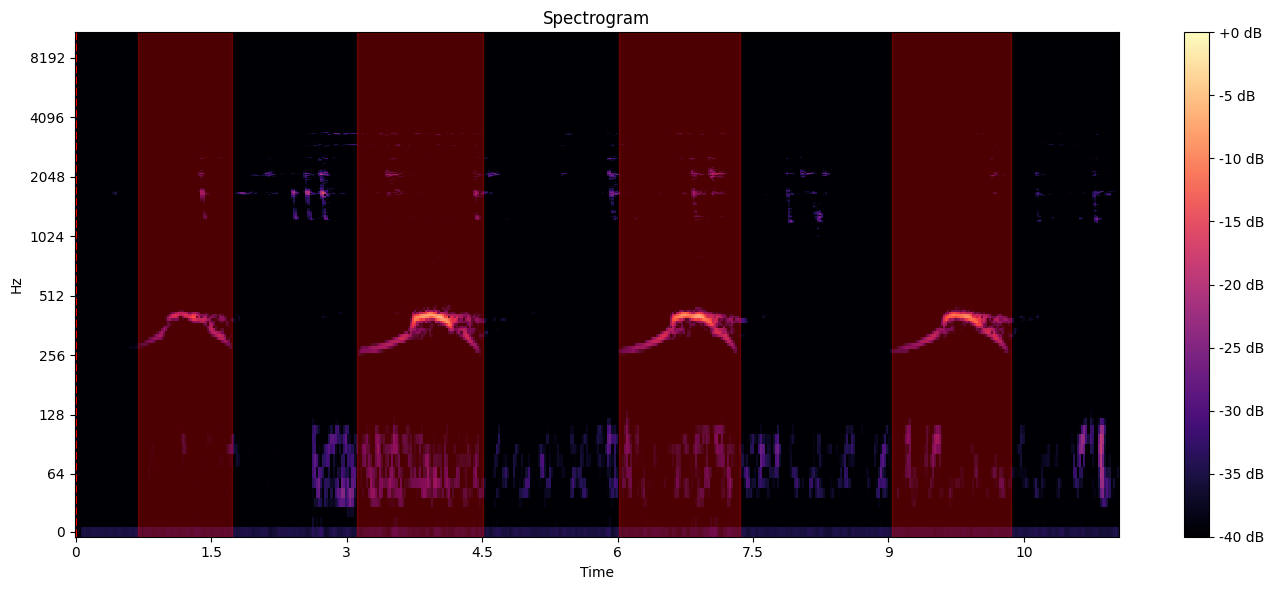

In [158]:
plot_spectrogram(y, sr, timestamps,threshold = -40)

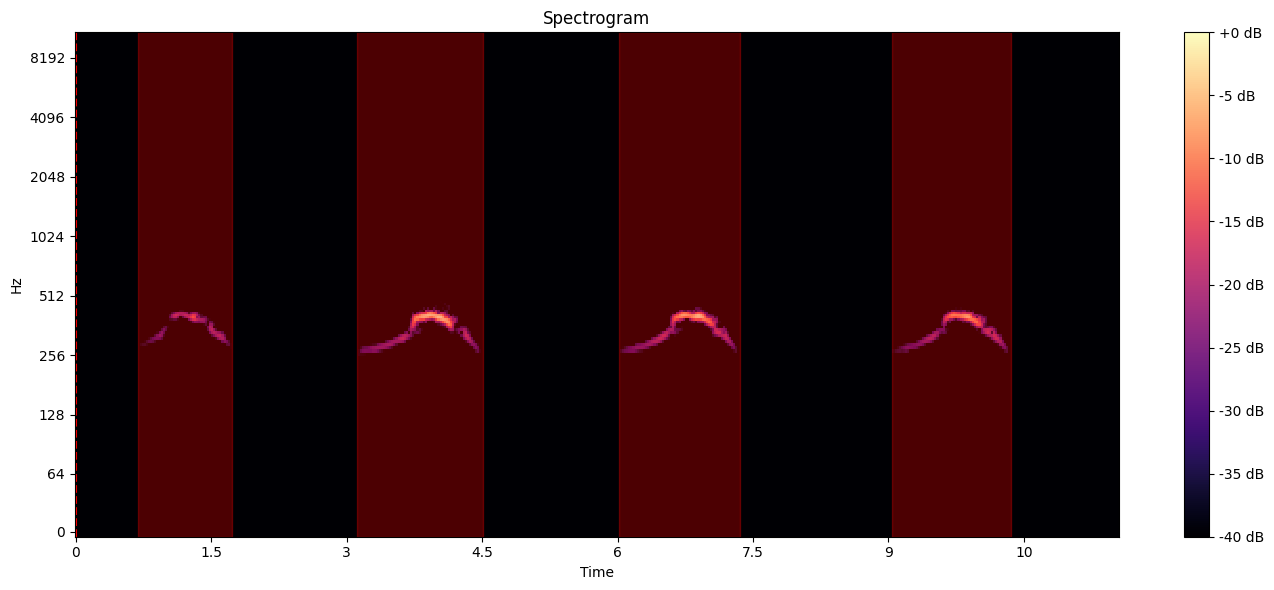

In [159]:
plot_spectrogram(y_denoised, sr, timestamps,threshold = -40)

In [23]:
import pandas as pd
# Create a list to hold the data for each row
data = []


for filename in files:
    if filename.endswith(('.wav','.mp3')):
        _,_,_,timestamps = detected_times(os.path.join(uncertain_folder,filename),threshold_factor=0.2,min_duration=0.5)
        # Populate the data list with rows
        for start_time, end_time in timestamps:
            data.append([filename, start_time, end_time, 'UNK'])
        # plot_spectrogram(y, sr, timestamps)
    
# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['filename', 'start_time', 'end_time', 'species'])

Detected minimum frequency: 0.0, maximum frequency: 721.3623046875. Using fallback values.


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 160624.
Note: Trying to resync...
/var/tmp/ipykernel_525375/281775197.py:145: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=target_sr)
/opt/conda/envs/audio/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).


In [16]:
files

['WEST UAFATO SM304491_0+1_20160323_093808trim.wav',
 'Magiagi Feb 2022_20211115_160004.wav',
 'Salelologa Aug 2021_f1842340352.mp3',
 '.ipynb_checkpoints',
 '139904_Macaulay_Doug Pratt.wav',
 'uncertain.csv',
 '161361541 Macaulay_Diana Novoa.wav']

In [24]:
# Save the DataFrame to a CSV file
df.to_csv(os.path.join(uncertain_folder,'uncertain.csv'), index=False)